In [1]:
import pandas as pd
import seaborn as sns
from statannotations.Annotator import Annotator
from be_predict_efficiency import predict as be_efficiency_model
import numpy as np 
import gpplot as gpp
from Bio import SeqIO
import matplotlib.pyplot as plt
gpp.set_aesthetics()

Looking at active vs inactive guides and seeing if they separate by BE-Hive editing efficiency model (Arbab et al 2020)

Note that the BEhive model uses scikit-learn==0.20.3 and thus requires the use of python version 3.7 to implement. 

For this reason, we recommend setting up a conda environment to run this notebook with the following Unix commands:

```conda create --name run_behive python=3.7```

```conda activate run_behive```

```pip install scikit-learn==0.20.3 jupyterlab pandas notebook seaborn gpplot statannotations openpyxl Bio ```

```python -m ipykernel install --user --name run_behive```

```jupyter notebook```


In [2]:
#Reading in all data that will be used

# Z-scores from activity-based selection TP53 screen etoposide arm
ABE= pd.read_excel("../../required_data/TP53/ABE_activity_zscores.xlsx",sheet_name="Sheet1")
CBE= pd.read_excel("../../required_data/TP53/CBE_activity_zscores.xlsx",sheet_name="Sheet1")

#subset to positive controls: guides that introduce missense, nonsense, or splice site mutations 
poscon_mutations=["Missense","Nonsense","Splice site"]

ABE=ABE[ABE["Mutation bin"].isin(poscon_mutations)].reset_index(drop=True)
CBE=CBE[CBE["Mutation bin"].isin(poscon_mutations)].reset_index(drop=True)

#further subset to positive controls: remove guides that introduce benign mutations
#this reduces the chance that guides are falsely called inactive due to lack of depletion
ABE_benign_guides=pd.read_csv("../../required_data/TP53/ABE_benign_TP53_etoposide_activitybased_zscores.csv")["sgRNA Target Sequence"].tolist()
ABE=ABE[ABE["sgRNA Target Sequence"].isin(ABE_benign_guides)==False].reset_index(drop=True)
CBE_benign_guides=pd.read_csv("../../required_data/TP53/CBE_benign_TP53_etoposide_activitybased_zscores.csv")["sgRNA Target Sequence"].tolist()
CBE=CBE[CBE["sgRNA Target Sequence"].isin(CBE_benign_guides)==False].reset_index(drop=True)

#retrieve guide-level beagle output to obtain the context sequences associated with each guide
guide_level_output=pd.read_table("../../required_data/TP53/tp53_ABE_3_9-guides.txt",usecols=['sgRNA Sequence', 'sgRNA Context Sequence','PAM Sequence', 'sgRNA Sequence Start Pos. (global)','sgRNA Orientation'])


#### Getting 50nt context sequences
Downloaded fasta of TP53 sequence from [ensembl](https://useast.ensembl.org/Homo_sapiens/Gene/Sequence?db=core;g=ENSG00000141510;r=17:7668421-7687490;t=ENST00000269305) (Download Sequence > Genomic sequence). Uploaded to this folder.



In [3]:
#getting full sequence of TP53
tp53_sequence=""
for seq_record in SeqIO.parse("../../required_data/TP53/Homo_sapiens_TP53_sequence.fa", "fasta"):
    tp53_sequence=tp53_sequence+ str(seq_record.seq)
    
guides_with_50ntcontext=guide_level_output.copy()

#helper function for get_50nt_context_TP53()
def reverse_complement(dna):
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    return "".join(complement[base] for base in reversed(dna))

#retrieves the 50nt context sequence for a TP53-targeting guide by using its start position and orientation
def get_50nt_context_TP53(orientation,global_start_pos):
    
    #According to ensembl, TP53 "ends" at global coordinate 7688146
    #... but this is the start because TP53 is on the reverse strand
    TP53_global_pos=7688146
    
    #get the position of this guide within the TP53 sequence 
    TP53_fasta_pos=TP53_global_pos-global_start_pos
    #guide INDEX within TP53 sequence is 1 more than POSITION b/c python 0-indexing
    TP53_fasta_index=TP53_fasta_pos+1 
    
    if orientation=="antisense":
        #50 nt context sequence begins 20 nucleotides before this position and ends 30 positions after
        #report reverse complement b/c antisense 
        return reverse_complement(tp53_sequence[TP53_fasta_index-30:TP53_fasta_index+20])     
    
    else:
        #if the guide is sense, it's going in the opposite direction of TP53
        #... thus, the reported guide start is actually the guide end. offset by 20nt to get guide start  
        TP53_fasta_index=TP53_fasta_index-20
        #since it is going in the opposite direction, the start/end are flipped, so extend 20 vs 30 nt in opposite directions
        return tp53_sequence[TP53_fasta_index-20:TP53_fasta_index+30]

#apply function to the data to get the 50nt context sequence of guides in TP53 screen 
guides_with_50ntcontext["50 nt context"]=guides_with_50ntcontext.apply(lambda x:get_50nt_context_TP53(x["sgRNA Orientation"],x["sgRNA Sequence Start Pos. (global)"]),axis=1)
guides_with_50ntcontext


,sgRNA Sequence,sgRNA Context Sequence,PAM Sequence,sgRNA Sequence Start Pos. (global),sgRNA Orientation,50 nt context
0,CTCCACTTCTTGTTCCCCAC,CATTCTCCACTTCTTGTTCCCCACTGACAG,TG,7669585,sense,GCCTGACTCAGACTGACATTCTCCACTTCTTGTTCCCCACTGACAG...
1,AACAAGAAGTGGAGAATGTC,GGGGAACAAGAAGTGGAGAATGTCAGTCTG,AG,7669591,antisense,GTGGGAGGCTGTCAGTGGGGAACAAGAAGTGGAGAATGTCAGTCTG...
2,GACTGACATTCTCCACTTCT,CTCAGACTGACATTCTCCACTTCTTGTTCC,TG,7669595,sense,AGACAGAAGGGCCTGACTCAGACTGACATTCTCCACTTCTTGTTCC...
3,AGAAGTGGAGAATGTCAGTC,AACAAGAAGTGGAGAATGTCAGTCTGAGTC,TG,7669595,antisense,GAGGCTGTCAGTGGGGAACAAGAAGTGGAGAATGTCAGTCTGAGTC...
4,AAGTGGAGAATGTCAGTCTG,CAAGAAGTGGAGAATGTCAGTCTGAGTCAG,AG,7669597,antisense,GGCTGTCAGTGGGGAACAAGAAGTGGAGAATGTCAGTCTGAGTCAG...
...,...,...,...,...,...,...
854,GCCTTCCGGGTCACTGCCAT,GACTGCCTTCCGGGTCACTGCCATGGAGGA,GG,7676593,sense,CCTCTTGCAGCAGCCAGACTGCCTTCCGGGTCACTGCCATGGAGGA...
855,ATGGCAGTGACCCGGAAGGC,CTCCATGGCAGTGACCCGGAAGGCAGTCTG,AG,7676593,antisense,GATCTGACTGCGGCTCCTCCATGGCAGTGACCCGGAAGGCAGTCTG...
856,CAGTGACCCGGAAGGCAGTC,ATGGCAGTGACCCGGAAGGCAGTCTGGCTG,TG,7676597,antisense,TGACTGCGGCTCCTCCATGGCAGTGACCCGGAAGGCAGTCTGGCTG...
857,AGTGACCCGGAAGGCAGTCT,TGGCAGTGACCCGGAAGGCAGTCTGGCTGC,GG,7676598,antisense,GACTGCGGCTCCTCCATGGCAGTGACCCGGAAGGCAGTCTGGCTGC...


## Run BEhive

While BEhive does not enable an option for TadCBE, this variant was evolved from the BE4 architecture, so assuming this is the closest substitute. For ABE, we used ABE8e, so ABE8 seems to be the closest variant. BEhive recommends the use of the mES cell type if the cell type employed is not mES or HEK293T, the two cell lines formally supported by the prediction model.

In [4]:
#ABE guides
be_efficiency_model.init_model(base_editor = 'ABE8', celltype = 'mES')
guides_with_50ntcontext["ABE activity"]=guides_with_50ntcontext["50 nt context"].apply(lambda x:be_efficiency_model.predict(x)["Predicted logit score"])

#CBE guides
be_efficiency_model.init_model(base_editor = 'BE4', celltype = 'mES')
guides_with_50ntcontext["CBE activity"]=guides_with_50ntcontext["50 nt context"].apply(lambda x:be_efficiency_model.predict(x)["Predicted logit score"])


/opt/homebrew/anaconda3/envs/run_behive/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
/opt/homebrew/anaconda3/envs/run_behive/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
/opt/homebrew/anaconda3/envs/run_behive/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, u

Model successfully initialized. Settings:
	celltype: mES
	base_editor: ABE8
Model successfully initialized. Settings:
	celltype: mES
	base_editor: BE4


## Identify distribution of BEhive scores in active vs. inactive guides



In [5]:
def plot_active_inactive(z_cutoff,ax):
    #inactive guides
    ABE_inactive=ABE[(ABE["Eto_RepAB_D21;z-score"]>=-z_cutoff)&(ABE["Eto_RepAB_D21;z-score"]<=z_cutoff)]["sgRNA Target Sequence"].tolist()
    #CBE_inactive=CBE[(CBE["Eto_RepAB_D21;z-score"]>=-z_cutoff)&(CBE["Eto_RepAB_D21;z-score"]<=z_cutoff)]["sgRNA Target Sequence"].tolist()
    
    #active guides
    ABE_active=ABE[ABE["Eto_RepAB_D21;z-score"]<-z_cutoff]["sgRNA Target Sequence"].tolist()
    #CBE_active=CBE[CBE["Eto_RepAB_D21;z-score"]<-z_cutoff]["sgRNA Target Sequence"].tolist()

    
    ABE_inactive_logits=guides_with_50ntcontext[guides_with_50ntcontext["sgRNA Sequence"].isin(ABE_inactive)]["ABE activity"].tolist()
    #CBE_inactive_logits=guides_with_50ntcontext[guides_with_50ntcontext["sgRNA Sequence"].isin(CBE_inactive)]["CBE activity"].tolist()
    
    ABE_active_logits=guides_with_50ntcontext[guides_with_50ntcontext["sgRNA Sequence"].isin(ABE_active)]["ABE activity"].tolist()
    #CBE_active_logits=guides_with_50ntcontext[guides_with_50ntcontext["sgRNA Sequence"].isin(CBE_active)]["CBE activity"].tolist()
        
    
    active_guide_logits= ABE_active_logits# + CBE_active_logits
    inactive_guide_logits=ABE_inactive_logits# + CBE_inactive_logits
    
    inactive_guide_logit_df=pd.DataFrame({"logit":inactive_guide_logits})
    active_guide_logit_df=pd.DataFrame({"logit":active_guide_logits})
    guide_logit_df=pd.concat([inactive_guide_logit_df,active_guide_logit_df],keys=["Inactive Guides","Active Guides"]).reset_index().rename(columns={"level_0":"guide_cat"})
    
    nobs = [str(x) for x in [len(inactive_guide_logits),len(active_guide_logits)]]
    nobs = ["n=" + i for i in nobs]
    
    sns.boxplot(guide_logit_df,x="guide_cat",y="logit",color="royalblue",ax=ax)
    pos = range(len(nobs))
    for tick,label in zip(pos,ax.get_xticklabels()):
        ax.text(pos[tick],1.1,
                nobs[tick],
                horizontalalignment='center',
                size='medium',
                color='black',
                weight='bold')
    
    annotator = Annotator(ax, [("Inactive Guides","Active Guides")], data=guide_logit_df, x="guide_cat", y='logit', order=["Inactive Guides","Active Guides"],verbose=False)
    annotator.configure(test='Mann-Whitney-ls', text_format='simple',fontsize=16,verbose=1) #this shows test name, actual p value
    annotator.apply_and_annotate()
    
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("Active guide cutoff: z< -"+str(z_cutoff) )

Inactive Guides vs. Active Guides: Mann-Whitney-Wilcoxon test smaller, P_val:1.569e-02 U_stat=1.383e+04
Inactive Guides vs. Active Guides: Mann-Whitney-Wilcoxon test smaller, P_val:7.607e-03 U_stat=1.311e+04
Inactive Guides vs. Active Guides: Mann-Whitney-Wilcoxon test smaller, P_val:5.580e-03 U_stat=1.203e+04


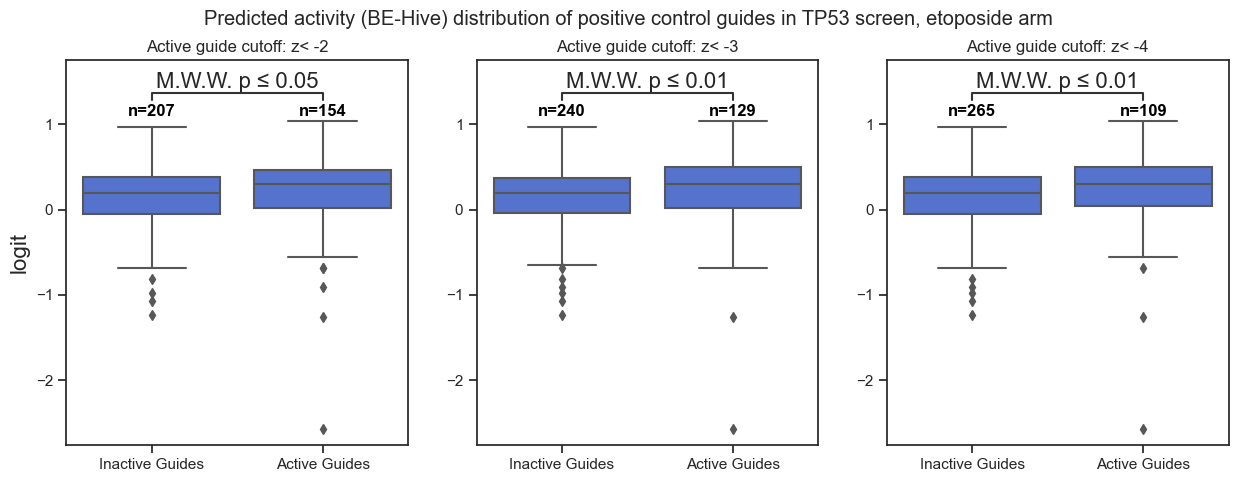

In [6]:
(fig,ax)=plt.subplots(1,3,figsize=(15,5))

plot_active_inactive(2,ax[0])
plot_active_inactive(3,ax[1])
plot_active_inactive(4,ax[2])

plt.suptitle("Predicted activity (BE-Hive) distribution of positive control guides in TP53 screen, etoposide arm")
ax[0].set_ylabel("logit",fontsize=16)

#gpp.savefig("BEHive_active_inactiveguides_TP53activitybased.pdf",bbox_inches="tight",dpi=600)

### Aside: how necessary is the 50 nt window?

BE-Hive editing efficiency model requires 50nt context sequences as input, yet Table S1, Arbab et al 2020 seems to suggest that nucloetids in such positions have minimal impact on the model output. Thus assessing how much logits for a single guide vary with a fixed 30 nt context sequence (4nt+20nt guide+ pam+ 3nt) 
and variable 16 nucleotides preceding and 4 nucleotides following. 


In [7]:
test_30ntwindow_df=guide_level_output.copy()
#initialize model for use with ABE8 editor
be_efficiency_model.init_model(base_editor = 'ABE8', celltype = 'mES')

#returns logits of activity model resulting from the first 16 and final 4 nt identities are randomized 100 times
#purpose: to identify extent to which 30nt context sequence suffices at predicting on-target activity 
def get_logits(context_30nts):
    logits=[]
    for i in range(100):
        sample_seq_mod= ("".join(np.random.choice(['A','G','C','T'],16))+
                         context_30nts+
                         "".join(np.random.choice(['A','G','C','T'],4)))
        logit=be_efficiency_model.predict(sample_seq_mod)
        logits.append(logit["Predicted logit score"])
    return logits 

test_30ntwindow_df["possible_100_logits"]=test_30ntwindow_df["sgRNA Context Sequence"].apply(lambda x: get_logits(x))
test_30ntwindow_df["logit_mean"]=test_30ntwindow_df["possible_100_logits"].apply(lambda x: np.mean(x))
test_30ntwindow_df["logit_max"]=test_30ntwindow_df["possible_100_logits"].apply(lambda x: np.max(x))
test_30ntwindow_df["logit_min"]=test_30ntwindow_df["possible_100_logits"].apply(lambda x: np.min(x))
print("logits range from ", round(test_30ntwindow_df["logit_min"].min(),4), 
      "to",round(test_30ntwindow_df["logit_max"].max(), 4) )
print("average range of logits per guide:",round(np.mean(abs(test_30ntwindow_df["logit_min"]-test_30ntwindow_df["logit_max"])),4))



Model successfully initialized. Settings:
	celltype: mES
	base_editor: ABE8
logits range from  -3.7715 to 1.2632
average range of logits per guide: 0.6464


The range of possible logit scores with a fixed 30nt context sequence and random nucleotides to fill the rest of the 50nt context sequence is quite wide, suggesting that the BE-Hive editing efficiency model performance does indeed necessitate the use of the entire 50nt context sequence.